In [92]:
import datetime
import os
import pprint
import tempfile
from typing import Dict, Text
import matplotlib.pyplot as plt

import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import surprise
import tensorflow as tf
import tensorflow_recommenders as tfrs

import tensorflow_datasets as tfds

# Load Data

In [111]:
df_ratings = pd.read_csv("ratings.csv")
df_content = pd.read_csv("content.csv")

In [112]:
df_ratings

,user_id,content_id,count,engaged_pct
0,000a544834,5c7ee2dd80,1,0.500000
1,000a544834,f8e78525fc,1,0.333333
2,000d2a6006,03bc268791,1,0.333333
3,000d2a6006,0b3e27a1d1,1,0.333333
4,000d2a6006,1d39c1c449,3,0.750000
...,...,...,...,...
120237,fff07ebc97,5df80dbcc0,2,0.500000
120238,fff07ebc97,bed9cfbff5,2,0.500000
120239,fff5c815f7,1c64591529,1,1.000000
120240,fff5c815f7,7e36cdfc2c,2,0.666667


In [113]:
df_content

,content_id
0,f260f3f3ce
1,bce874342a
2,bbf2753b99
3,a9b6c93c3a
4,0c93cc1338
...,...
578,2ca0fce09f
579,5c57c25574
580,58bb410bc8
581,a842a97d1a


# Modeling
Implement both retrieval and ranking models. Track with MlFlow. This system is for: user -> item. Generally calculated using a dot product for matrix factorization. Item -> item is usualy on a product page to recommend similar products. Can get item to item using cosine similarity measure.  Optimizing for a single objective (multi object is avaailable - ratings and clicks)

<strong>Retrieval</strong> - two tower - https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
takes a user id and returns a subset of good candidates. Oversimplies model to implicit (engaged implicit +, viewed implicit -). The oversimplification speeds up the model.

<strong>ranking</strong> - https://www.tensorflow.org/recommenders/examples/basic_ranking
takes ad user id and a subset of good candidates and returns the best candidate. Here we use engagement pct as a proxy for an explicit rating. ranking is inherently expensive, so we want to only rank a small subset of possibilities.

## Load data into TensorFlow

In [5]:
# mlflow autolog not working with this model
# mlflow.tensorflow.autolog() #keras autolog is deprecated

In [110]:
# global variables used in getting predictions
USER_ID = "82216a2c7d"
CONTENT_ID = "49a9f915b5"

ratings_raw = tf.data.Dataset.from_tensor_slices(
    dict(df_ratings[["user_id", "content_id"]])
)

ratings_raw = tf.data.Dataset.from_tensor_slices(
    dict(df_ratings[["user_id", "content_id", "engaged_pct"]])
)
content_raw = tf.data.Dataset.from_tensor_slices(dict(df_content[["content_id"]]))
#print("implicit: ", ratings_raw.element_spec)
print("ratings: ", ratings_raw.element_spec)
print("content: ", content_raw.element_spec)

ratings:  {'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'content_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'engaged_pct': TensorSpec(shape=(), dtype=tf.float64, name=None)}
content:  {'content_id': TensorSpec(shape=(), dtype=tf.string, name=None)}


## Retrieval

In [115]:
# map data
ratings_retrieval = ratings_raw.map(
    lambda x: {"user_id": x["user_id"], "content_id": x["content_id"]}
)

content_retrieval = content_raw.map(lambda x: x["content_id"])

print("users_content length: ", len(ratings_retrieval))
print("content length: ", len(content_retrieval))

users_content length:  120242
content length:  583


In [116]:
# Ratings: Shuffle and split into train and test

tf.random.set_seed(42)
shuffled_ratings = ratings_retrieval.shuffle(
    buffer_size=1_000, seed=42, reshuffle_each_iteration=False
)
print("length of shuffled: ", len(shuffled_ratings))

to_take_ratings = int(len(shuffled_ratings) * 0.75)
remaining_ratings = int(len(shuffled_ratings) - to_take_ratings)

print("training set size: ", to_take_ratings)
print("test set size: ", remaining_ratings)

train_retrieval = shuffled_ratings.take(to_take_ratings)
test_retrieval = shuffled_ratings.skip(to_take_ratings).take(remaining_ratings)

length of shuffled:  120242
training set size:  90181
test set size:  30061


In [117]:
# get uniques

content_ids_retrieval = content_retrieval.batch(1_000)
user_ids_retrieval = ratings_retrieval.batch(1_000).map(lambda x: x["user_id"])

unique_content_ids_retrieval = np.unique(np.concatenate(list(content_ids_retrieval)))
unique_user_ids_retrieval = np.unique(np.concatenate(list(user_ids_retrieval)))

print("number of unique titles: ", len(unique_content_ids_retrieval))
print("number of unique users: ", len(unique_user_ids_retrieval))

# look at top 10
unique_content_ids_retrieval[:5]

number of unique titles:  583
number of unique users:  7066


array([b'00733d9430', b'008c372b81', b'01af663e58', b'024775977e',
       b'02538907fb'], dtype=object)

### Define Model

In [118]:
# latent variables
embedding_dimension = 32

In [119]:
user_retrieval_model = tf.keras.Sequential(
    [
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids_retrieval, mask_token=None
        ),
        tf.keras.layers.Embedding(
            len(unique_user_ids_retrieval) + 1, embedding_dimension
        ),
    ]
)

In [120]:
content_retrieval_model = tf.keras.Sequential(
    [
        tf.keras.layers.StringLookup(
            vocabulary=unique_content_ids_retrieval, mask_token=None
        ),
        tf.keras.layers.Embedding(
            len(unique_content_ids_retrieval) + 1, embedding_dimension
        ),
    ]
)

#k = the number of top scoring candidates to retrieve for metric evaluation. 
metrics = tfrs.metrics.FactorizedTopK(
    candidates=content_retrieval.batch(128).map(content_retrieval_model), k = 100
)
TASK_RETRIEVAL = tfrs.tasks.Retrieval(metrics=metrics)

In [121]:
# defined as the dot product between user and item embeddings. corresponds to matrix factorization.


class RetrievalModel(tfrs.Model):
    def __init__(self, user_model, content_model):
        super().__init__()
        self.content_model: tf.keras.Model = content_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = TASK_RETRIEVAL

    def compute_loss(
        self, features: Dict[Text, tf.Tensor], training=False
    ) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])

        # And pick out the content features and pass them into the coontent model,
        # getting embeddings back.
        positive_content_embeddings = self.content_model(features["content_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_content_embeddings)

### Fit and Evaluate

In [122]:
model_retrieval = RetrievalModel(user_retrieval_model, content_retrieval_model)
model_retrieval.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [123]:
cached_train_retrieval = (
    train_retrieval.shuffle(buffer_size=100_000).batch(8192).cache()
)
cached_test_retrieval = test_retrieval.batch(4096).cache()

In [124]:
# need shapes for mlflow
cached_train_retrieval.element_spec

{'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'content_id': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [125]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

fitted = model_retrieval.fit(cached_train_retrieval, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
12/12 [==============================] - 11s 728ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0070 - factorized_top_k/top_5_categorical_accuracy: 0.0512 - factorized_top_k/top_10_categorical_accuracy: 0.1078 - factorized_top_k/top_50_categorical_accuracy: 0.4212 - factorized_top_k/top_100_categorical_accuracy: 0.6182 - loss: 59708.5000 - regularization_loss: 0.0000e+00 - total_loss: 59708.5000
Epoch 2/5
12/12 [==============================] - 7s 585ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0159 - factorized_top_k/top_5_categorical_accuracy: 0.1035 - factorized_top_k/top_10_categorical_accuracy: 0.1975 - factorized_top_k/top_50_categorical_accuracy: 0.6368 - factorized_top_k/top_100_categorical_accuracy: 0.8893 - loss: 52319.5563 - regularization_loss: 0.0000e+00 - total_loss: 52319.5563
Epoch 3/5
12/12 [==============================] - 7s 579ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0217 - factorized_top_k/top_5_categorical_accuracy:

In [126]:
model_retrieval.evaluate(cached_test_retrieval, return_dict=True)

8/8 [==============================] - 3s 248ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0106 - factorized_top_k/top_10_categorical_accuracy: 0.0236 - factorized_top_k/top_50_categorical_accuracy: 0.1042 - factorized_top_k/top_100_categorical_accuracy: 0.1933 - loss: 28590.3835 - regularization_loss: 0.0000e+00 - total_loss: 28590.3835


{'factorized_top_k/top_1_categorical_accuracy': 0.0013971590669825673,
 'factorized_top_k/top_5_categorical_accuracy': 0.010611755773425102,
 'factorized_top_k/top_10_categorical_accuracy': 0.023585377261042595,
 'factorized_top_k/top_50_categorical_accuracy': 0.10418815165758133,
 'factorized_top_k/top_100_categorical_accuracy': 0.1933402121067047,
 'loss': 10040.7841796875,
 'regularization_loss': 0,
 'total_loss': 10040.7841796875}

Test set performance is much worse than training performance. This is due to two factors:
* Our model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and content features that help the model generalize better to unseen data.
* The model is re-recommending some of users' already seen content. These known-positives can crowd test content out of top K recommendations. This can be address by excluding previously seen content from test recommendations. This approach is relatively common in the recommender systems literature, but wasn't implemented here. If not recommending past content is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times.

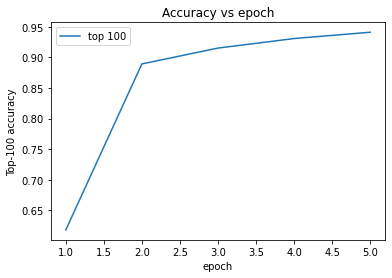

In [127]:
# look at accuracy changing by epoch
num_validation_runs = len(fitted.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]

#plt.plot(epochs, fitted.history["factorized_top_k/top_1_categorical_accuracy"], label="top 1")
#plt.plot(epochs, fitted.history["factorized_top_k/top_10_categorical_accuracy"], label="top 10")
plt.plot(epochs, fitted.history["factorized_top_k/top_100_categorical_accuracy"], label="top 100")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

### Get Content Recommendations - Brute Force
The most straightforward way of retrieving top candidates in response to a query is to do it via brute force: compute user-movie scores for all possible movies, sort them, and pick a couple of top recommendations.

As the number of candidate grows, the amount of time needed grows linearly: with 10 million candidates, serving top candidates would take 250 milliseconds. This is clearly too slow for a live service. This is where approximate mechanisms come in. We can use ScaNN in TFRS to accomplish this via the tfrs.layers.factorized_top_k.ScaNN layer.

In [128]:
# Create BruteForce model that takes in raw user_id features, and
brute_force_index = tfrs.layers.factorized_top_k.BruteForce(model_retrieval.user_model)

# recommends content out of the entire content dataset.
brute_force_index.index_from_dataset(
    tf.data.Dataset.zip(
        (
            content_retrieval.batch(100),
            content_retrieval.batch(100).map(model_retrieval.content_model),
        )
    )
)

# Get recommendations for:
_, content_ids_recommended = brute_force_index(tf.constant([USER_ID]))
print(
    f"content_id recommendations for user {USER_ID}: {content_ids_recommended[0, :5]}"
)

content_id recommendations for user 82216a2c7d: [b'49a9f915b5' b'20b0745a31' b'a533f2f57a' b'a1671b9953' b'73e16a0447']


### Create Retrieval Model Artifact

In [129]:
cwd = os.getcwd()
print(cwd)
path = os.path.join(cwd, "retrieval_model")
tf.saved_model.save(brute_force_index, path)

/Users/zach/Documents/GitHub/Recommenders


INFO:tensorflow:Assets written to: /Users/zach/Documents/GitHub/Recommenders/retrieval_model/assets


INFO:tensorflow:Assets written to: /Users/zach/Documents/GitHub/Recommenders/retrieval_model/assets


## Ranking
* pointwise - candidates are considered independently of each other (currently using)
* listwise - candidates pairs are considered, consider the ordering of the entire list
* can use explicit feedback (engage pct) as a ranking

### Load Data into TensorFlow

In [130]:
ratings_raw.element_spec

{'user_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'content_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'engaged_pct': TensorSpec(shape=(), dtype=tf.float64, name=None)}

In [131]:
# use user_rating
ratings_ranking = ratings_raw.map(
    lambda x: {
        "user_id": x["user_id"],
        "content_id": x["content_id"],
        "engaged_pct": x["engaged_pct"],
    }
)

In [132]:
# suffle and train/test split
tf.random.set_seed(42)
shuffled_ranking = ratings_ranking.shuffle(
    buffer_size=1_000, seed=42, reshuffle_each_iteration=False
)
print("length of shuffled: ", len(shuffled_ranking))

to_take_ranking = int(len(shuffled_ranking) * 0.75)
remaining_ranking = int(len(shuffled_ranking) - to_take_ranking)

print("training set size: ", to_take_ranking)
print("test set size: ", remaining_ranking)

train_ranking = shuffled_ranking.take(to_take_ranking)
test_ranking = shuffled_ranking.skip(to_take_ranking).take(remaining_ranking)

shuffled_ranking.element_spec

length of shuffled:  120242
training set size:  90181
test set size:  30061


{'user_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'content_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'engaged_pct': TensorSpec(shape=(), dtype=tf.float64, name=None)}

In [133]:
# get uniques. all from ratings
content_ids_ranking = ratings_ranking.batch(1_000_000).map(lambda x: x["content_id"])
user_ids_ranking = ratings_ranking.batch(1_000_000).map(lambda x: x["user_id"])

unique_content_ids_ranking = np.unique(np.concatenate(list(content_ids_ranking)))
unique_user_ids_ranking = np.unique(np.concatenate(list(user_ids_ranking)))

### Define Model

In [134]:
class RankingDefinitionModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_user_ids_ranking, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_user_ids_ranking) + 1, embedding_dimension
                ),
            ]
        )

        # Compute embeddings for content_ids.
        self.content_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_content_ids_ranking, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_content_ids_ranking) + 1, embedding_dimension
                ),
            ]
        )

        # Compute predictions.
        self.ratings = tf.keras.Sequential(
            [
                # Learn multiple dense layers.
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
                # Make rating predictions in the final layer.
                tf.keras.layers.Dense(1),
            ]
        )

    def call(self, inputs):

        user_id, content_id = inputs

        user_embedding = self.user_embeddings(user_id)
        content_embedding = self.content_embeddings(content_id)

        return self.ratings(tf.concat([user_embedding, content_embedding], axis=1))

In [135]:
# user_id, content_id
RankingDefinitionModel()(([USER_ID], [CONTENT_ID]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01159916]], dtype=float32)>

In [136]:
TASK_RANKING = tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [137]:
class RankingsModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingDefinitionModel()
        self.task: tf.keras.layers.Layer = TASK_RANKING

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model((features["user_id"], features["content_id"]))

    def compute_loss(
        self, features: Dict[Text, tf.Tensor], training=False
    ) -> tf.Tensor:
        labels = features.pop("engaged_pct")

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

### Fit and Evaluate

In [138]:
model_ranking = RankingsModel()
model_ranking.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [139]:
cached_train_ranking = train_ranking.shuffle(100_000).batch(8192).cache()
cached_test_ranking = test_ranking.batch(4096).cache()

In [140]:
model_ranking.fit(
    cached_train_ranking,
    epochs=5,
    validation_data=cached_test_ranking,
    validation_freq=5,
)

Epoch 1/5
12/12 [==============================] - 2s 53ms/step - root_mean_squared_error: 0.3281 - loss: 0.1021 - regularization_loss: 0.0000e+00 - total_loss: 0.1021
Epoch 2/5
12/12 [==============================] - 0s 20ms/step - root_mean_squared_error: 0.2487 - loss: 0.0632 - regularization_loss: 0.0000e+00 - total_loss: 0.0632
Epoch 3/5
12/12 [==============================] - 0s 18ms/step - root_mean_squared_error: 0.2483 - loss: 0.0629 - regularization_loss: 0.0000e+00 - total_loss: 0.0629
Epoch 4/5
12/12 [==============================] - 0s 19ms/step - root_mean_squared_error: 0.2480 - loss: 0.0627 - regularization_loss: 0.0000e+00 - total_loss: 0.0627
Epoch 5/5
12/12 [==============================] - 1s 71ms/step - root_mean_squared_error: 0.2477 - loss: 0.0624 - regularization_loss: 0.0000e+00 - total_loss: 0.0624 - val_root_mean_squared_error: 0.2515 - val_loss: 0.0615 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0615


In [141]:
model_ranking.evaluate(cached_test_ranking, return_dict=True)

8/8 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.2515 - loss: 0.0629 - regularization_loss: 0.0000e+00 - total_loss: 0.0629


{'root_mean_squared_error': 0.2514699101448059,
 'loss': 0.06148726865649223,
 'regularization_loss': 0,
 'total_loss': 0.06148726865649223}

### Get Content Recommendations - Ranking

In [142]:
final_ratings = {}

content_ids_from_retrieval = content_ids_recommended[0]
print("content from retrieval (unsorted content_ids): ", content_ids_from_retrieval)

for content_id in content_ids_from_retrieval:
    content_id = content_id.numpy()
    final_ratings[content_id] = model_ranking(
        # user | content_id
        {"user_id": np.array([f"{USER_ID}"]), "content_id": np.array([content_id])}
    )

print("----------------")
print("Ranked Content")
print(f"Ratings for user {USER_ID}:")
print("content_id | score")


for content_id, score in sorted(
    final_ratings.items(), key=lambda x: x[1], reverse=True
):
    print(f"{content_id}: {score}")

content from retrieval (unsorted content_ids):  tf.Tensor(
[b'49a9f915b5' b'20b0745a31' b'a533f2f57a' b'a1671b9953' b'73e16a0447'
 b'c7d5f7710d' b'487d868f96' b'9f943715a3' b'19e9799800' b'639ae113f9'], shape=(10,), dtype=string)
----------------
Ranked Content
Ratings for user 82216a2c7d:
content_id | score
b'a533f2f57a': [[0.67427635]]
b'487d868f96': [[0.6728412]]
b'73e16a0447': [[0.66920125]]
b'a1671b9953': [[0.6617259]]
b'639ae113f9': [[0.65509045]]
b'c7d5f7710d': [[0.6438377]]
b'20b0745a31': [[0.6413824]]
b'49a9f915b5': [[0.6396617]]
b'9f943715a3': [[0.6361379]]
b'19e9799800': [[0.6309099]]


### Create Ranking Model Artifact

In [143]:
cwd = os.getcwd()
print(cwd)
ranking_path = os.path.join(cwd, "ranking_model")

tf.saved_model.save(model_ranking, ranking_path)

/Users/zach/Documents/GitHub/Recommenders


INFO:tensorflow:Assets written to: /Users/zach/Documents/GitHub/Recommenders/ranking_model/assets


INFO:tensorflow:Assets written to: /Users/zach/Documents/GitHub/Recommenders/ranking_model/assets
